# Cointegration

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
EWAdf = pd.read_csv('data/EWA_history.csv', skiprows=1)
EWAdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
EWAdf['Date'] = pd.to_datetime(EWAdf['Date'], errors='coerce')
EWAdf['Close'] = pd.to_numeric(EWAdf['Close'], errors='coerce')

EWCdf = pd.read_csv('data/EWC_history.csv', skiprows=1)
EWCdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
EWCdf['Date'] = pd.to_datetime(EWCdf['Date'], errors='coerce')
EWCdf['Close'] = pd.to_numeric(EWCdf['Close'], errors='coerce')

## Visualize EWA and EWC

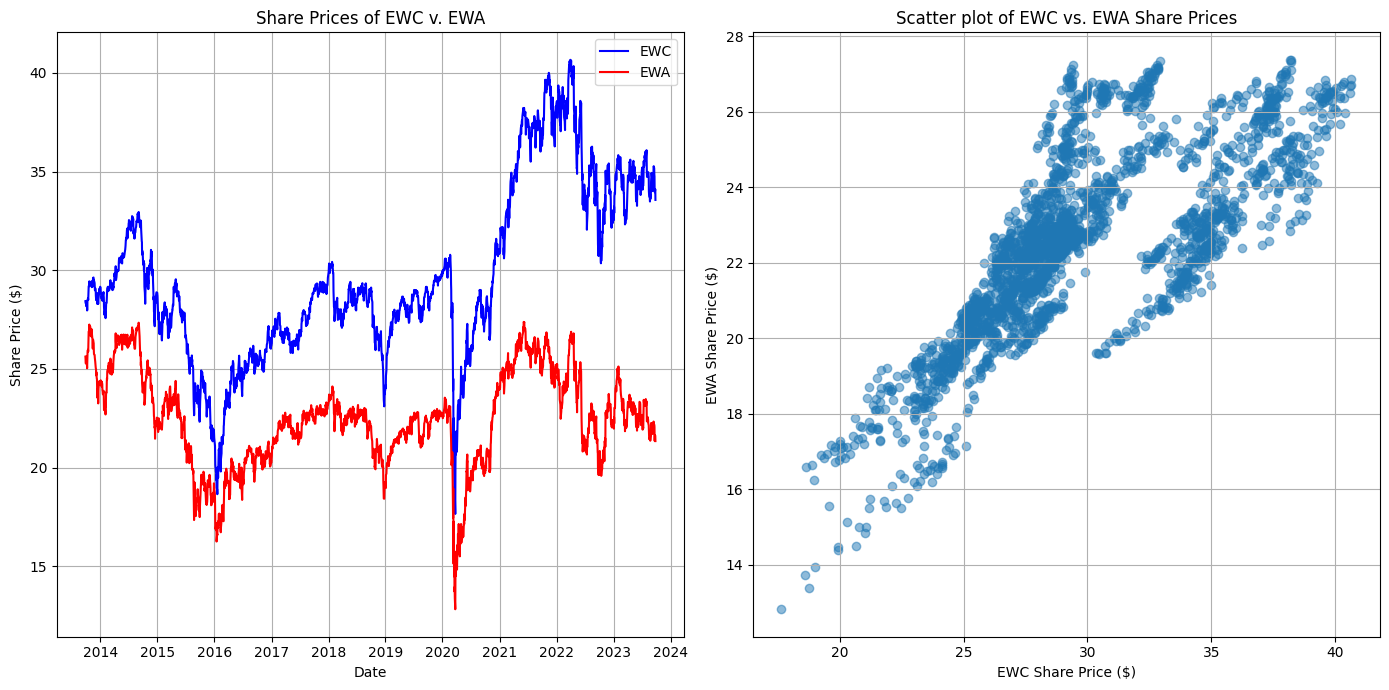

In [3]:
merged_df = pd.merge(EWCdf[['Date', 'Close']], EWAdf[['Date', 'Close']], on='Date', how='inner', suffixes=('_EWC', '_EWA'))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Line plot
axes[0].plot(merged_df['Date'], merged_df['Close_EWC'], label='EWC', color='blue')
axes[0].plot(merged_df['Date'], merged_df['Close_EWA'], label='EWA', color='red')
axes[0].set_title('Share Prices of EWC v. EWA')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Share Price ($)')
axes[0].legend()
axes[0].grid(True)

# Scatter plot
axes[1].scatter(merged_df['Close_EWC'], merged_df['Close_EWA'], alpha=0.5)
axes[1].set_title('Scatter plot of EWC vs. EWA Share Prices')
axes[1].set_xlabel('EWC Share Price ($)')
axes[1].set_ylabel('EWA Share Price ($)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Cointegrated ADF (CADF) Test

Results for EWC as Independent:
Test Statistic: -2.34488373399533
P-value: 0.1579002487388782
Critical Values: {'1%': -3.4329694597063978, '5%': -2.8626972631809684, '10%': -2.567386056042265}

Results for EWA as Independent:
Test Statistic: -1.539370213561277
P-value: 0.5139534148165379
Critical Values: {'1%': -3.4329694597063978, '5%': -2.8626972631809684, '10%': -2.567386056042265}

Optimal Hedge Ratio: 0.41006804610478864


C:\Users\Arjun\AppData\Local\Temp\ipykernel_10856\4088437618.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = sm.OLS(ewa_price, sm.add_constant(ewc_price)).fit().params[1]


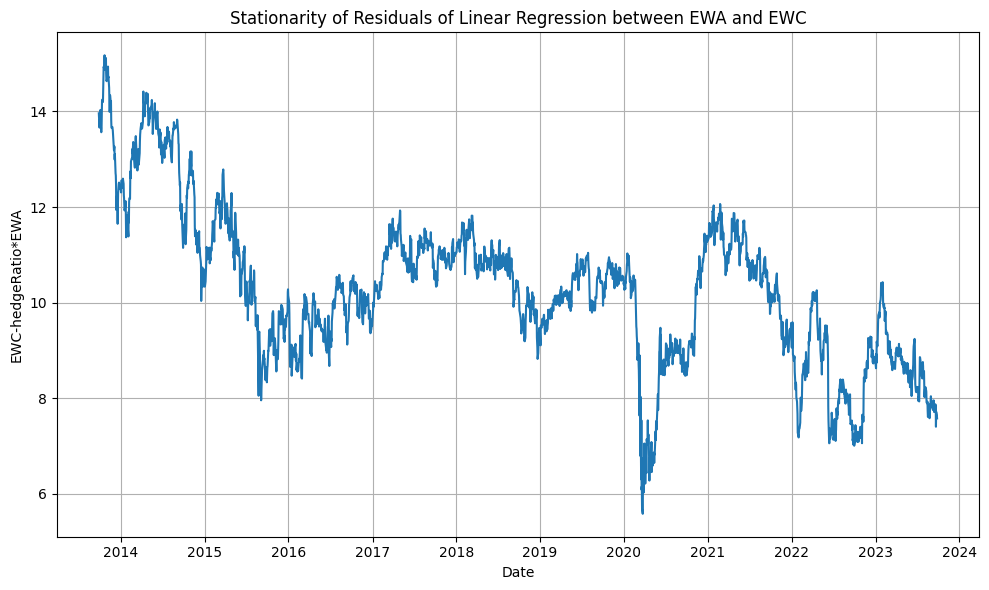

In [4]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def CADF(y, x):
    result = sm.OLS(y, x).fit()    
    residuals = y - result.predict(x)
    adf_stats = adfuller(residuals)
    return adf_stats

ewc_price = EWCdf['Close']
ewa_price = EWAdf['Close']

# EWC independent
t_stat_ewc_as_independent, p_val_ewc_as_independent, usedlag, nobs, crit_values, icbest = CADF(ewa_price, sm.add_constant(ewc_price))

# EWA independent
t_stat_ewa_as_independent, p_val_ewa_as_independent, usedlag, nobs, crit_values, icbest = CADF(ewc_price, sm.add_constant(ewa_price))

print("Results for EWC as Independent:")
print(f"Test Statistic: {t_stat_ewc_as_independent}")
print(f"P-value: {p_val_ewc_as_independent}")
print(f"Critical Values: {crit_values}")

print("\nResults for EWA as Independent:")
print(f"Test Statistic: {t_stat_ewa_as_independent}")
print(f"P-value: {p_val_ewa_as_independent}")
print(f"Critical Values: {crit_values}")

# Optimal Order
if t_stat_ewc_as_independent < t_stat_ewa_as_independent:
    hedge_ratio = sm.OLS(ewa_price, sm.add_constant(ewc_price)).fit().params[1]
else:
    hedge_ratio = 1 / sm.OLS(ewc_price, sm.add_constant(ewa_price)).fit().params[1]

print(f"\nOptimal Hedge Ratio: {hedge_ratio}")

# Plot Residuals
merged_df = pd.merge(EWCdf, EWAdf, on='Date', suffixes=('_EWC', '_EWA'))
ewc_price = merged_df['Close_EWC']
ewa_price = merged_df['Close_EWA']

if t_stat_ewc_as_independent < t_stat_ewa_as_independent:
    residuals = ewa_price - hedge_ratio * ewc_price
else:
    residuals = ewc_price - hedge_ratio * ewa_price

plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], residuals)
plt.title('Stationarity of Residuals of Linear Regression between EWA and EWC')
plt.xlabel('Date')
plt.ylabel('EWC-hedgeRatio*EWA')
plt.grid(True)
plt.tight_layout()
plt.show()

The most negative t-stat, produced by EWC, is used as the independent variable to calculate the hedge ratio.

Interpretation: If we are long 1 unit of EWC, we would want to short approximately 0.41 units of EWA to be relatively protected from movements in EWC. Conversely, if we are short 1 unit of EWC, we would go long 0.41 units of EWA.

## Johansen Test

In [5]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

merged_df = pd.merge(EWAdf, EWCdf, on='Date', suffixes=('_EWA', '_EWC'))
prices_df = merged_df[['Close_EWA', 'Close_EWC']]

johansen_result = coint_johansen(prices_df, det_order=0, k_ar_diff=1)

print('Trace Statistics:')
print(johansen_result.lr1)
print('Critical values of trace statistics:')
print(johansen_result.cvt)

print('\nEigen Statistics:')
print(johansen_result.lr2)
print('Critical values of eigen statistics:')
print(johansen_result.cvm)


Trace Statistics:
[11.85084575  3.31256222]
Critical values of trace statistics:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen Statistics:
[8.53828353 3.31256222]
Critical values of eigen statistics:
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


Interpretation [r=0 v. r>0, r<=1 v. r>1]

Trace  
-> r=0 vs r>0: fail to reject the null hypothesis of r=0  
-> r≤1 vs r>1: reject the null hypothesis of r=1 at the 90% significance level but fail to reject it at the 95% level

Eigen   
-> r=0 vs r=1: fail to reject the null hypothesis of r=0  
-> r≤1 vs r>1: reject the null hypothesis of r=1 at the 90% significance level but fail to reject it at the 95% level

Confirms the possibility of one cointegration.

## Introduce IGE ETF

In [6]:
IGEdf = pd.read_csv('data/IGE_history.csv', skiprows=1)
IGEdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
IGEdf['Date'] = pd.to_datetime(IGEdf['Date'], errors='coerce')
IGEdf['Close'] = pd.to_numeric(IGEdf['Close'], errors='coerce')

## 3-Way Cointegration Johansen Test

In [7]:
merged_df = pd.merge(EWCdf, EWAdf, on='Date', suffixes=('_EWC', '_EWA'))
merged_df = pd.merge(merged_df, IGEdf, on='Date')
merged_df = merged_df.dropna(subset=['Close_EWC', 'Close_EWA', 'Close'])

data = merged_df[['Close_EWC', 'Close_EWA', 'Close']].values
result = coint_johansen(data, det_order=0, k_ar_diff=1)

print("Trace Statistics:")
print(result.lr1)
print("Critical values of trace statistics:")
print(result.cvt)

print("\nEigen Statistics:")
print(result.lr2)
print("Critical values of eigen statistics:")
print(result.cvm)

Trace Statistics:
[25.9378331   9.40402754  0.50049199]
Critical values of trace statistics:
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen Statistics:
[16.53380556  8.90353555  0.50049199]
Critical values of eigen statistics:
[[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


There is no evidence of cointegration for any r value.

## Backtesting a Linear Mean-Reverting Strategy on a Portfolio

C:\Users\Arjun\AppData\Local\Temp\ipykernel_10856\2535615421.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_lagged = merged_df['Portfolio'].shift(1).fillna(method="bfill")
C:\Users\Arjun\AppData\Local\Temp\ipykernel_10856\2535615421.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_life = -np.log(2) / model.params[1]


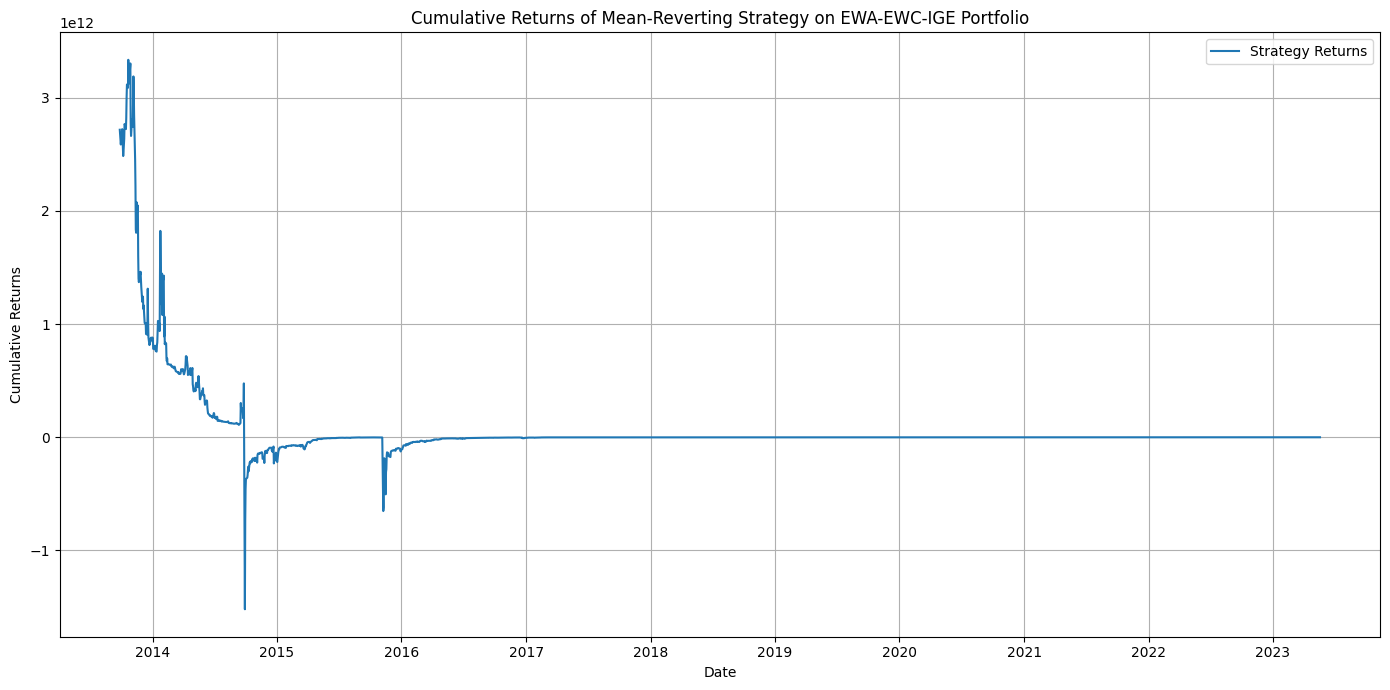

In [8]:
eigenvector = result.evec[:, 0]
merged_df['Portfolio'] = merged_df['Close_EWC'] * eigenvector[0] + merged_df['Close_EWA'] * eigenvector[1] + merged_df['Close'] * eigenvector[2]

portfolio_lagged = merged_df['Portfolio'].shift(1).fillna(method="bfill")
delta = merged_df['Portfolio'] - portfolio_lagged
model = sm.OLS(delta, sm.add_constant(portfolio_lagged)).fit()
half_life = -np.log(2) / model.params[1]

merged_df['MovingAvg'] = merged_df['Portfolio'].rolling(window=int(half_life)).mean()
merged_df['MovingStd'] = merged_df['Portfolio'].rolling(window=int(half_life)).std()

merged_df['Z'] = (merged_df['Portfolio'] - merged_df['MovingAvg']) / merged_df['MovingStd']
merged_df['Position'] = -merged_df['Z']

merged_df['Return'] = merged_df['Portfolio'].pct_change()
merged_df['StrategyReturn'] = merged_df['Return'] * merged_df['Position']
merged_df['CumulativeStrategyReturns'] = (1 + merged_df['StrategyReturn']).cumprod() - 1

plt.figure(figsize=(14,7))
plt.plot(merged_df['Date'], merged_df['CumulativeStrategyReturns'], label='Strategy Returns')
plt.title('Cumulative Returns of Mean-Reverting Strategy on EWA-EWC-IGE Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Convergence to 0 indicates that the three are not cointegrated for the entire time-period.

## Kalman Filter

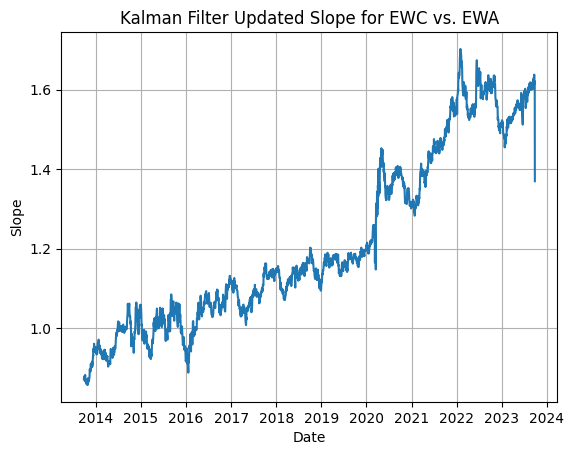

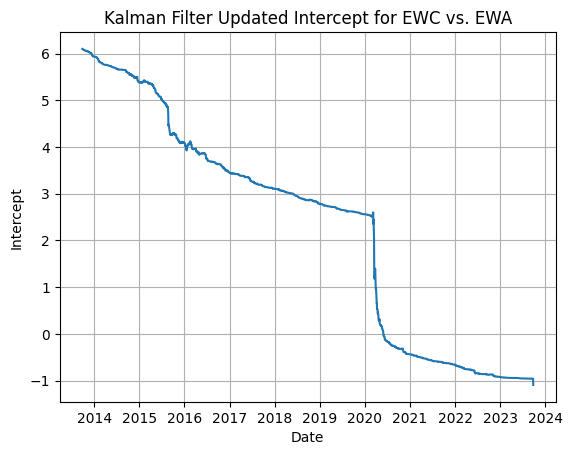

In [9]:
# Initialization
T = len(EWAdf)
Q = 1e-3  # Process noise
Ve = 0.001  # Measurement noise
Vw = np.diag([0.001, 0.001])  # Covariance noise
beta = np.zeros((2, T))
R = np.zeros((2, 2, T))
y = EWCdf['Close'].values
x = np.vstack([np.ones(T), EWAdf['Close'].values]).T
beta[:, 0] = np.linalg.lstsq(x, y, rcond=None)[0]
R[:, :, 0] = Q

e_values = np.zeros(T)
Q_values = np.zeros(T)

for t in range(1, T):
    # Prediction
    beta[:, t] = beta[:, t-1]
    R[:, :, t] = R[:, :, t-1] + Vw
    
    # Measurement prediction
    y_hat = x[t, :].dot(beta[:, t])
    
    # Measurement update
    e = y[t] - y_hat
    Q_t = x[t, :].dot(R[:, :, t]).dot(x[t, :]) + Ve     # Measurement variance prediction
    K = R[:, :, t].dot(x[t, :]) / Q_t       # Kalman gain
    beta[:, t] = beta[:, t] + K * e
    R[:, :, t] = R[:, :, t] - np.outer(K, x[t, :].dot(R[:, :, t]))

    e_values[t] = e
    Q_values[t] = Q_t

# Plot
plt.plot(EWAdf['Date'], beta[1, :])
plt.title('Kalman Filter Updated Slope for EWC vs. EWA')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.grid(True)
plt.show()

# Plot
plt.plot(EWAdf['Date'], beta[0, :])  
plt.title('Kalman Filter Updated Intercept for EWC vs. EWA')
plt.xlabel('Date')
plt.ylabel('Intercept')
plt.grid(True)
plt.show()

## Kalman Filter Mean Reversion Strategy

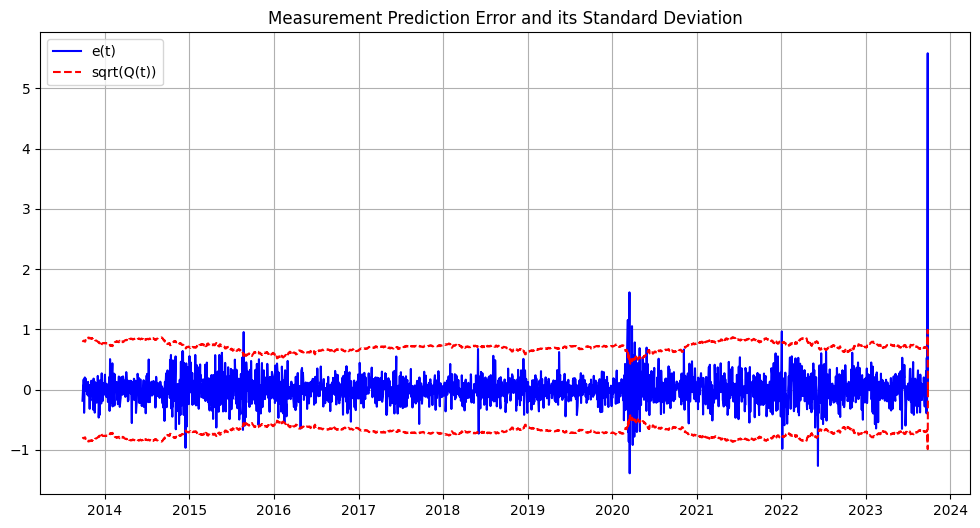

C:\Users\Arjun\AppData\Local\Temp\ipykernel_10856\3555868624.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  positions = pd.Series(positions).fillna(method='ffill').values


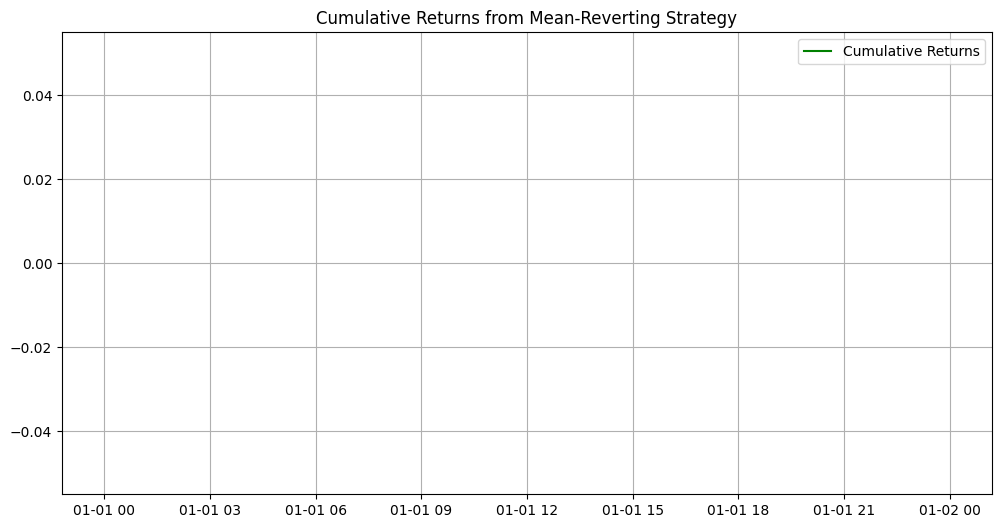

In [10]:
# Entry and Exit Signals
longsEntry = e_values < -np.sqrt(Q_values)
longsExit = e_values > -np.sqrt(Q_values)
shortsEntry = e_values > np.sqrt(Q_values)
shortsExit = e_values < np.sqrt(Q_values)

# Plot e(t) and standard deviation
plt.figure(figsize=(12, 6))
plt.plot(EWAdf['Date'], e_values, label='e(t)', color='blue')
plt.plot(EWAdf['Date'], np.sqrt(Q_values), label='sqrt(Q(t))', linestyle='--', color='red')
plt.plot(EWAdf['Date'], -np.sqrt(Q_values), linestyle='--', color='red')
plt.title('Measurement Prediction Error and its Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

# Strategy
positions = np.zeros(T)
positions[longsEntry] = 1
positions[shortsEntry] = -1
positions[longsExit] = 0
positions[shortsExit] = 0
positions = pd.Series(positions).fillna(method='ffill').values

returns = positions * (EWCdf['Close'].pct_change().values - beta[1, :] * EWAdf['Close'].pct_change().values)

cum_returns = np.cumsum(returns)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(EWAdf['Date'], cum_returns, label='Cumulative Returns', color='green')
plt.title('Cumulative Returns from Mean-Reverting Strategy')
plt.grid(True)
plt.legend()
plt.show()